# Perturbating images
See [this article](https://arxiv.org/abs/1704.03296)

In [1]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import ListedColormap

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

import numpy as np

## 0. Load datset

In [2]:
# Load dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '5')

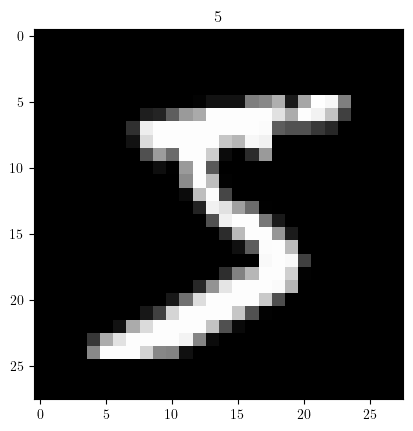

In [3]:
image, label = train[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)

In [4]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [5]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 1. Train simple model

In [6]:
device = torch.device('mps')

In [7]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [8]:
def train_model(model, optimizer, loss_fn):
    torch.manual_seed(42)
    epochs = 1#3

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [9]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

model = nn.Sequential(
    nn.Flatten(),
    nn.ReLU(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [10]:
train_model(model, optimizer, loss_fn)

[EPOCH 1/1] Train loss: 0.34690 | Test loss: 0.14156, Test acc: 95.81%


## 2. Attacks
### 2.0 Boilerplate

In [11]:
from tqdm import tqdm

In [12]:
def evaluate_attack(subset, kernel_size, step, annotate_image):
    kx_range = range(0, 28, step)
    ky_range = range(0, 28, step)

    accuracies = [np.zeros((len(kx_range), len(ky_range))) for _ in range(10)]
    losses = [np.zeros((len(kx_range), len(ky_range))) for _ in range(10)]

    for digit in tqdm(range(10)):
        for i, kx in enumerate(kx_range):
            for j, ky in enumerate(ky_range):
                attack = datasets.MNIST(
                    root="data",
                    train=False,
                    download=True,
                    transform=Lambda(
                        lambda x: annotate_image(kx, ky, kernel_size, ToTensor()(x).squeeze())
                    ),
                )
                attack = torch.utils.data.Subset(attack, range(subset))

                #image, _ = attack[0]
                #plt.imshow(image.squeeze(), cmap="gray")
                #plt.title(label)
                #plt.show()

                attack_loader = DataLoader(
                    torch.utils.data.Subset(attack, [i for i, (_, y) in enumerate(attack) if y == digit]),
                    batch_size=BATCH_SIZE,
                    shuffle=False
                )

                test_loss, test_acc = 0, 0
                model.eval()
                with torch.inference_mode():
                    for X, y in attack_loader:
                        X, y = X.to(device), y.to(device)
                        test_pred = model(X)

                        test_loss += loss_fn(test_pred, y)
                        test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

                    if len(attack_loader) != 0:
                        test_loss /= len(attack_loader)
                        test_acc /= len(attack_loader)

                accuracies[digit][j][i] = test_acc
                losses[digit][j][i] = test_loss

    return accuracies, losses

In [13]:
def visualize_accuracies(accuracies, kernel_size, step):
    fig, axs = plt.subplots(2, 5, figsize=(12,6))

    plt.suptitle(f"Accuracies per attack zone\n Kernel size: {kernel_size}   |   Step: {step}")
    for digit in range(10):
        image, _ = torch.utils.data.Subset(train, [i for i, (_, y) in enumerate(train) if y == digit])[0]
        image = torch.flip(image, [0, 1]) # idk why I need to flip it but alright
        
        axs[digit//5][digit%5].imshow(accuracies[digit])
        axs[digit//5][digit%5].contour(image.squeeze(), levels=[0.1], colors='red', origin='image')
        axs[digit//5][digit%5].set_title(f"Digit = {digit}")
    plt.show()

    plt.imshow(np.mean(np.array(accuracies), axis=0))
    plt.colorbar()
    plt.title("Accuracies per attack zone\n All classes average")
    plt.plot()

### 2.1 Invert attack
Attacked pixels receive the following transformation:
$$x\longleftarrow 1-x$$

In [15]:
SUBSET = 1000
KERNEL_SIZE = 4
STEP = 1

def invert_attack(kx, ky, kernel_size, image):
    h = kernel_size//2
    image[ky-h:ky+kernel_size-h, kx-h:kx+kernel_size-h] = 1 - image[ky-h:ky+kernel_size-h, kx-h:kx+kernel_size-h]
    return image

accuracies, losses = evaluate_attack(SUBSET, KERNEL_SIZE, STEP, invert_attack)

100%|██████████| 10/10 [06:06<00:00, 36.61s/it]


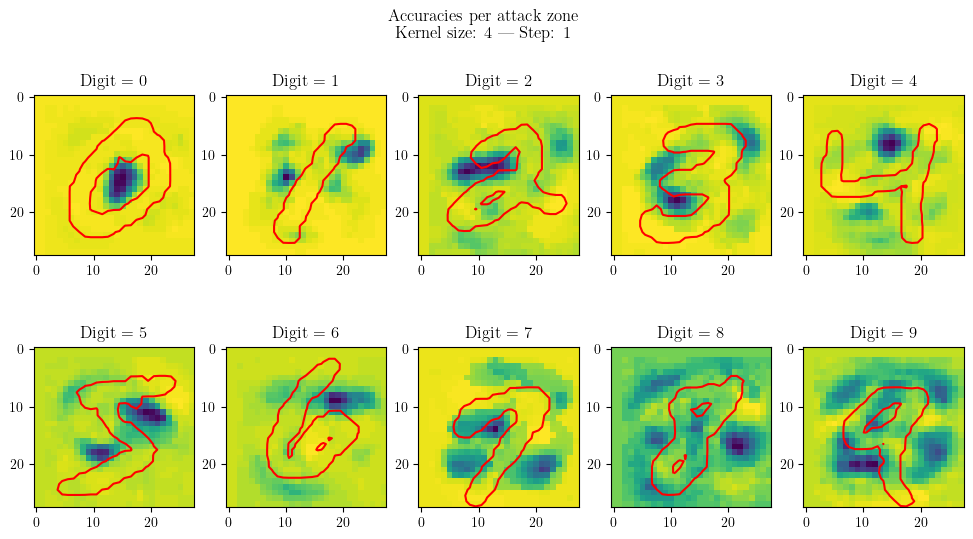

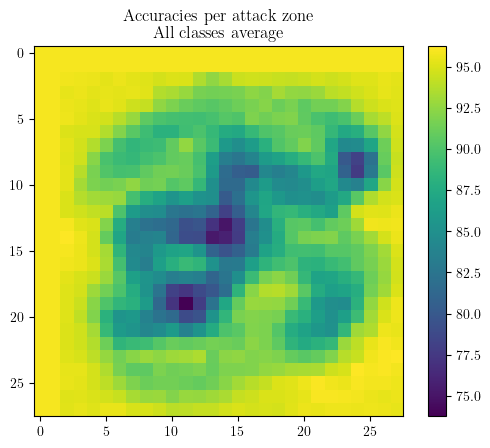

In [16]:
visualize_accuracies(accuracies, KERNEL_SIZE, STEP)

### 2.2 Random attack
Attacked pixels receive the following transformation:
$$x\longleftarrow \mathcal{U}([0, 1[)$$

In [17]:
SUBSET = 1000
KERNEL_SIZE = 4
STEP = 1

def random_attack(kx, ky, kernel_size, image):
    h = kernel_size // 2
    image[ky-h:ky+kernel_size-h, kx-h:kx+kernel_size-h] = torch.rand(image[ky-h:ky+kernel_size-h, kx-h:kx+kernel_size-h].shape)
    return image

accuracies, losses = evaluate_attack(SUBSET, KERNEL_SIZE, STEP, invert_attack)

100%|██████████| 10/10 [06:09<00:00, 36.98s/it]


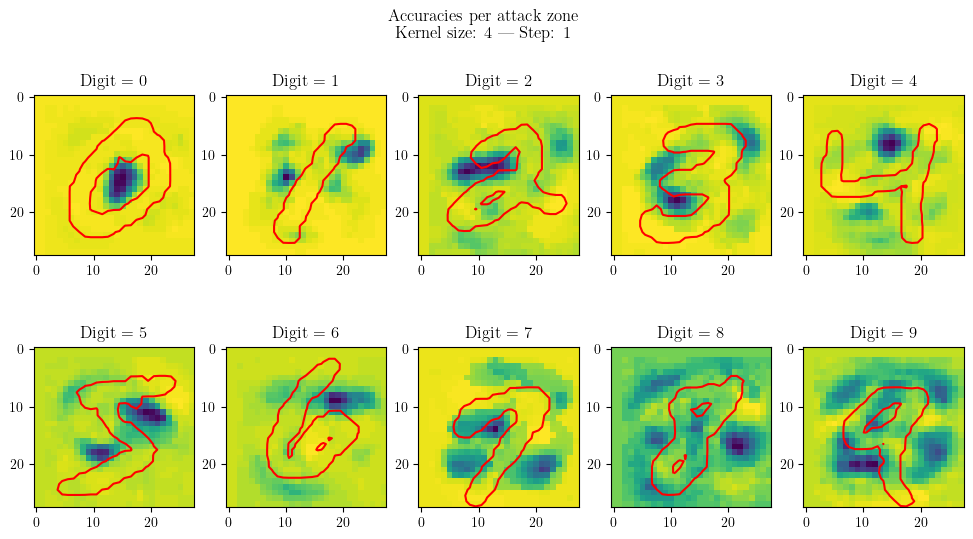

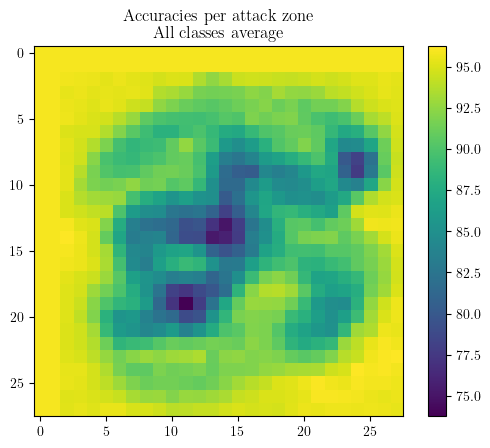

In [18]:
visualize_accuracies(accuracies, KERNEL_SIZE, STEP)

## 3. LRP after attacks

In [25]:
def invert_attack(kx, ky, kernel_size, image):
    h = kernel_size//2
    image[ky-h:ky+kernel_size-h, kx-h:kx+kernel_size-h] = 1 - image[ky-h:ky+kernel_size-h, kx-h:kx+kernel_size-h]
    return image

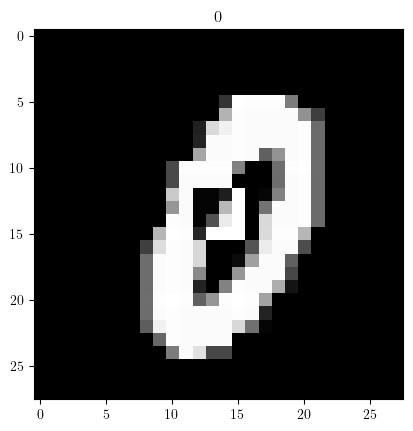

tensor(8, device='mps:0')


In [84]:
i=0
image = train.data[train.targets == 0][2]
image = image.squeeze()/255.

image = invert_attack(14, 14, 4, image)
plt.imshow(image, cmap="gray")
plt.title(label)
plt.show()

print(torch.argmax(model(image.reshape(1,784).to(device))))

In [88]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)

In [89]:
X = train.data.reshape((60000, 784)).detach().numpy()
T = train.targets.detach().numpy()

In [119]:
my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)

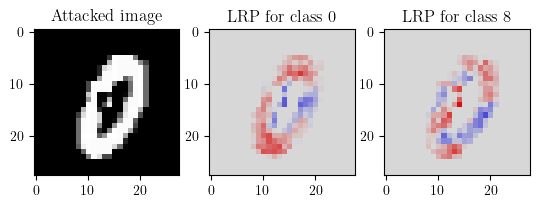

In [127]:
attacked_image = X[T==0][2].reshape(28, 28)
attacked_image = invert_attack(14, 14, 4, attacked_image)
attacked_image = attacked_image.reshape(784)

A = [np.array([attacked_image, attacked_image])] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

nb_digits = len(train.classes)
R = [None] * L + [A[L] * (np.array([0, 8]).reshape(2, 1)==np.arange(nb_digits))]

def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * np.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(W[l], l)
    b = rho(B[l], l)

    z = incr(A[l].dot(w)+b, l)
    s = R[l+1] / z
    c = s.dot(w.T)
    R[l] = A[l] * c

w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0.-1
hb = A[0]*0.+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R[0] = A[0]*c - lb*cp - hb*cm

fig, axs = plt.subplots(1, 3)

axs[0].imshow(attacked_image.reshape(28, 28), cmap="gray")
axs[0].set_title("Attacked image")

b = 10*(np.abs(R[0][0])**3.0).mean()**(1.0/3)
axs[1].imshow(R[0][0].reshape(28, 28), cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
axs[1].set_title("LRP for class 0")

b = 10*(np.abs(R[0][1])**3.0).mean()**(1.0/3)
axs[2].imshow(R[0][1].reshape(28, 28), cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
axs[2].set_title("LRP for class 8")

plt.show()

## 4. Attacks using LRP

In [17]:
SUBSET = 100

X = train.data.reshape((60000, 784)).detach().numpy()
X = X[:SUBSET]
T = train.targets.detach().numpy()
T = T[:SUBSET]

In [18]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)

In [19]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

nb_digits = len(train.classes)

In [20]:
R_classical_LRP = [None] * L + [A[L] * (T[:,None]==np.arange(nb_digits))]

def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * np.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(W[l], l)
    b = rho(B[l], l)

    z = incr(A[l].dot(w)+b, l)
    s = R_classical_LRP[l+1] / z
    c = s.dot(w.T)
    R_classical_LRP[l] = A[l] * c

w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0.-1
hb = A[0]*0.+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R_classical_LRP[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R_classical_LRP[0] = A[0]*c - lb*cp - hb*cm

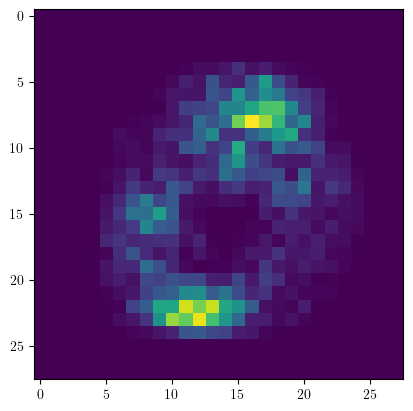

In [27]:
plt.imshow(np.mean(np.abs(R_classical_LRP[0][T==0]), axis=0).reshape((28, 28)))

In [85]:
STEP = 5

## -- RANDOM --
train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
X = train.data.reshape((60000, 784)).detach().numpy()
X = X[:SUBSET]
T = train.targets.detach().numpy()
T = T[:SUBSET]

rand_accuracies = []
M = [[] for _ in X]
for _ in range(0, 28*28, STEP):
    for i in range(len(X)):
        for _ in range(STEP):
            pixel = np.random.randint(0, 28*28)
            while pixel in M[i]:
                pixel = np.random.randint(0, 28*28)
                if len(M[i]) >= 784:
                    break

            M[i].append(pixel)
            X[i][pixel] = 255 - X[i][pixel]

    acc = 0
    model.eval()
    with torch.inference_mode():
        for x, y in zip(X, T):
            x = torch.from_numpy(x.reshape(1, 784)).to(device).type(torch.float32)
            test_pred = model(x)

            acc += accuracy_fn(torch.tensor(y).to(device), test_pred.argmax(dim=1))

        if len(X) != 0:
            acc /= len(X)
    rand_accuracies.append(acc)

## -- LRP --
relevance = np.mean(np.abs(R_classical_LRP[0]), axis=0)
relevance = -relevance # the most relevant pixels should be the less likely to be attacked
relevance = np.exp(relevance) / sum(np.exp(relevance)) # softmax

M = [[] for _ in X]
lrp_accuracies = []
train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
X = train.data.reshape((60000, 784)).detach().numpy()
X = X[:SUBSET]
T = train.targets.detach().numpy()
T = T[:SUBSET]
for _ in range(0, 28*28, STEP):
    for i in range(len(X)):
        for _ in range(STEP):
            pixel = np.random.choice(28*28, p=relevance)
            while pixel in M[i]:
                pixel = np.random.randint(0, 28*28)
                if len(M[i]) >= 784:
                    break

            M[i].append(pixel)
            X[i][pixel] = 255 - X[i][pixel]

    acc = 0
    model.eval()
    with torch.inference_mode():
        for x, y in zip(X, T):
            x = torch.from_numpy(x.reshape(1, 784)).to(device).type(torch.float32)
            test_pred = model(x)

            acc += accuracy_fn(torch.tensor(y).to(device), test_pred.argmax(dim=1))

        if len(X) != 0:
            acc /= len(X)
    lrp_accuracies.append(acc)

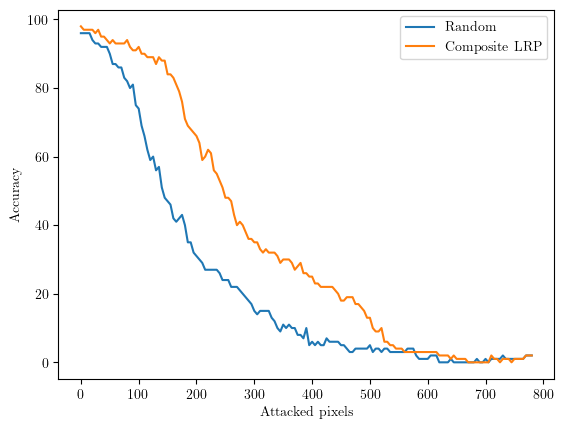

In [88]:
plt.plot(list(range(0, 28*28, STEP)), rand_accuracies, label="Random")
plt.plot(list(range(0, 28*28, STEP)), lrp_accuracies, label="Composite LRP")
plt.xlabel("Attacked pixels")
plt.ylabel("Accuracy")
plt.legend()
plt.show()